In [1]:
%load_ext autoreload
%autoreload 2
from train import *
from train_config import load_config

### sequential training

In [2]:
##################### different fixation and delay, duration in [10, 20, 40, 80]
############ different trainable input/output weights for each task epoch, 3 rank per task epoch
save_name = 'cxtrnn_seq_gating3_ioZ_a0pt1_sigr0pt05_PPAA_DMDM_sigs_dur_z2_nx2dx2_sd0'
############ shared trainable input/output weights, shared full rank for all task epoch
# save_name = 'cxtrnn_seq_gatingall_a0pt1_sigr0pt05_PPAA_DMDM_sigs_dur_z2_nx2dx2_sd0'

##################### shared fixation/delay, duration in max(np.random.geometric(0.1), 5)
############ different trainable input/output weights for each task epoch, 3 rank per task epoch
# save_name = 'cxtrnn_seq_gating3_ioZ_a0pt1_sigr0pt05_PPAA_DMDM_sigs_minT5_nx2dx2_sd0'
############ shared trainable input/output weights, shared full rank for all task epoch
# save_name = 'cxtrnn_seq_gatingall_a0pt1_sigr0pt05_PPAA_DMDM_sigs_minT5_nx2dx2_sd0'

config = load_config(save_name)
config['retrain'] = False
model, tr_loss_arr, ts_loss_arr = train_rnn_sequential(**config)

4571


Text(0, 0.5, 'test loss')

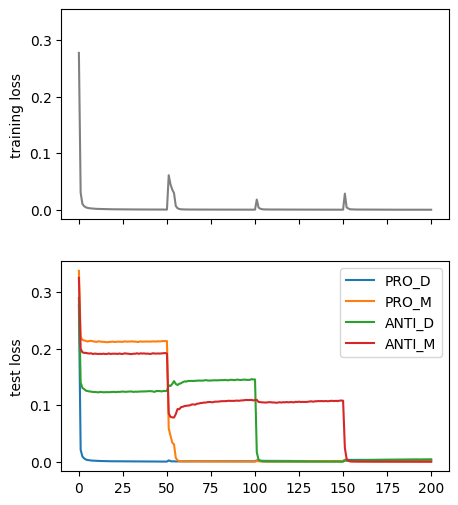

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True, sharey=True)
axes[0].plot(tr_loss_arr, color='gray')
for itask in range(len(config['task_list'])):
    axes[1].plot(ts_loss_arr[itask], color=f'C{itask}', label=config['task_list'][itask])
axes[1].legend()
axes[0].set_ylabel('training loss')
axes[1].set_ylabel('test loss')

### visualize gating for each task epoch

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


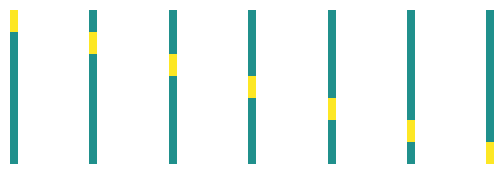

In [4]:
dim_z = len(config['z_list'])
fig, axes = plt.subplots(1, dim_z, figsize=(dim_z, 2))
for iz in range(dim_z):
    z_t = torch.zeros(dim_z, device=next(model.parameters()).device)
    z_t[iz] = 1
    gating = model.gating(z_t.unsqueeze(0))
    gating = gating.detach().cpu().numpy()[0]
    print(gating)
    axes[iz].imshow(gating[:, None], vmin=-1, vmax=1)
    axes[iz].axis('off')

### checkpoints

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_list = torch.load(config['save_dir'] + '/ckpt_list.pth', map_location=torch.device(device))

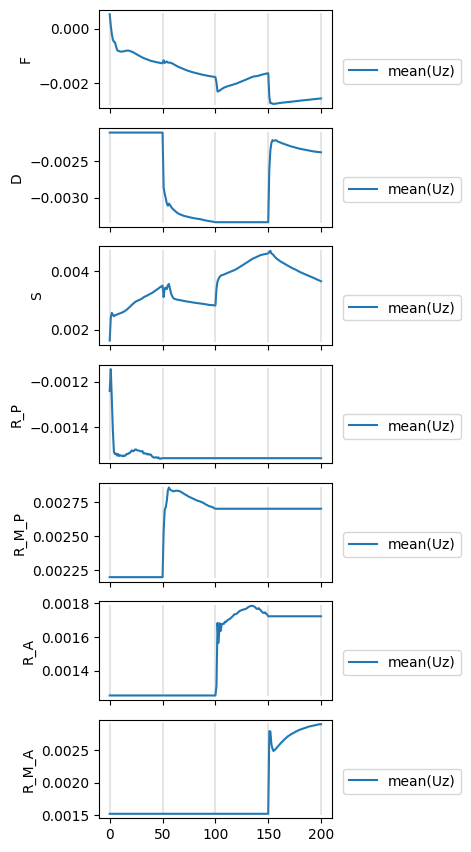

In [6]:
U_arr = np.array([ckpt['U'].detach().cpu().numpy() for ckpt in ckpt_list])
V_arr = np.array([ckpt['V'].detach().cpu().numpy() for ckpt in ckpt_list])
fig, axes = plt.subplots(dim_z, 1, figsize=(3, 1.5*dim_z), sharex=True)
for iz in range(dim_z):
    z_t = torch.zeros(dim_z, device=next(model.parameters()).device)
    z_t[iz] = 1
    gating = model.gating(z_t.unsqueeze(0)).detach().cpu().numpy()[0]
    plot_u = (U_arr * np.sqrt(gating)).mean((-1, -2))
    # plot_v = (V_arr * np.sqrt(gating)).mean((-1, -2))
    axes[iz].plot(plot_u, label='mean(Uz)')
    # axes[iz].plot(plot_v, label='mean(Vz)')
    axes[iz].set_ylabel(config['z_list'][iz])
    axes[iz].legend(loc=(1.05, 0.25))
    # ymax = max(plot_u.max(), plot_v.max())
    # ymin = min(plot_u.min(), plot_v.min())
    ymax = plot_u.max()
    ymin = plot_u.min()
    for x in range(len(config['task_list']) + 1):
        axes[iz].plot([x * config['num_iter'] / 10] * 2, [ymin, ymax], alpha=0.2, color='gray')

### example trials

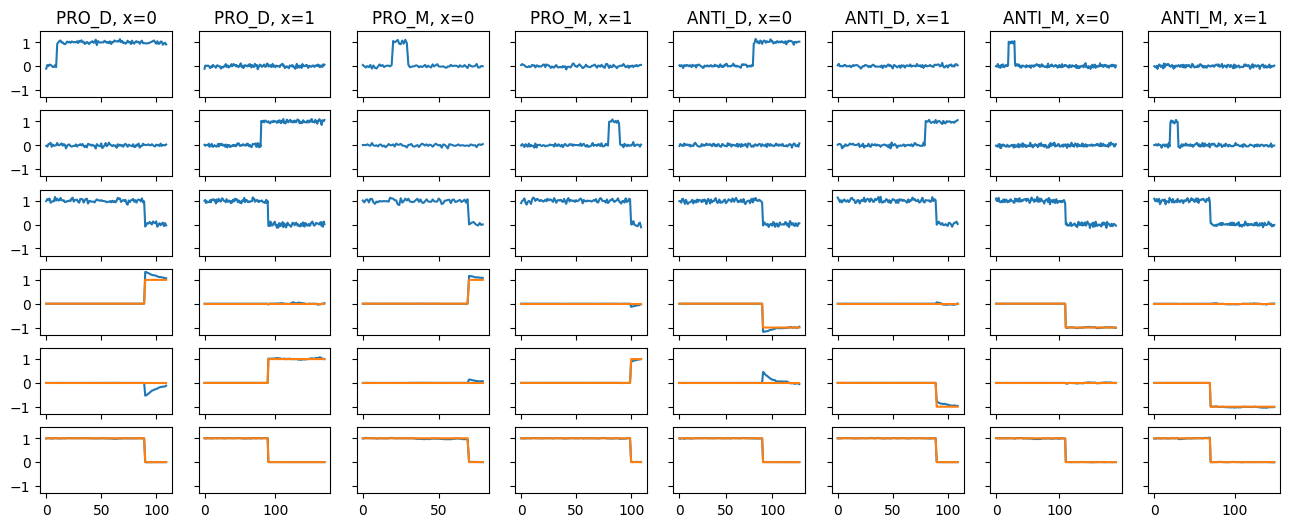

In [7]:
i_ckpt = -1
ckpt = ckpt_list[i_ckpt]
model.load_state_dict(ckpt)

x_set = [0, 1]
d_stim = config.get('d_stim', np.pi / 2)
fig, axes = plt.subplots(6, len(config['task_list']) * len(x_set), 
                         figsize=(2 * len(config['task_list']) * len(x_set), 6),
                         sharey=True, sharex='col')
for itask, task in enumerate(config['task_list']):
    epoch_str = task_epoch(task, epoch_type=config.get('epoch_type', 1))
    sig_y = 0
    sig_s = config['sig_s']
    p_stay = config['p_stay']
    min_Te = config['min_Te']
    for ix, x in enumerate(x_set):
        sy, boundaries = compose_trial(epoch_str, {'theta_task': x}, sig_s, sig_y, p_stay, min_Te, d_stim=d_stim)
        all_Te = np.diff([0] + list(boundaries))
        z = [[config['z_list'].index(cur)] * Te for cur, Te in zip(epoch_str.split('->'), all_Te)]
        z = np.array([j for i in z for j in i])[:, None]
        if config.get('fixation_type', 1) == 2:
            sy['s'][:, -1] = 1 - sy['s'][:, -1]
            sy['y'][:, -1] = 1 - sy['y'][:, -1]
        syz = np.concatenate([sy['s'], sy['y'], z], axis=-1)
        syz = torch.tensor(syz[:, None, :], dtype=torch.float32)
        syz = syz.to(next(model.parameters()).device)
        s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
        z = F.one_hot(z.to(torch.int64), num_classes=dim_z).float()
        with torch.no_grad():
            out = model(s, z)
        ########### plot #########
        icol = len(x_set) * itask + ix
        axes[0, icol].set_title(f'{task}, x={x}')
        for iax in range(3):
            axes[iax, icol].plot(s[:, :, iax].cpu().numpy())
        for iax in range(3):
            axes[iax + 3, icol].plot(out[:, :, iax].cpu().numpy())
            axes[iax + 3, icol].plot(y[:, :, iax].cpu().numpy())
fig.savefig(config['save_dir'] + f'/example_ckpt{i_ckpt}.png', bbox_inches='tight')

### custom epoch sequence

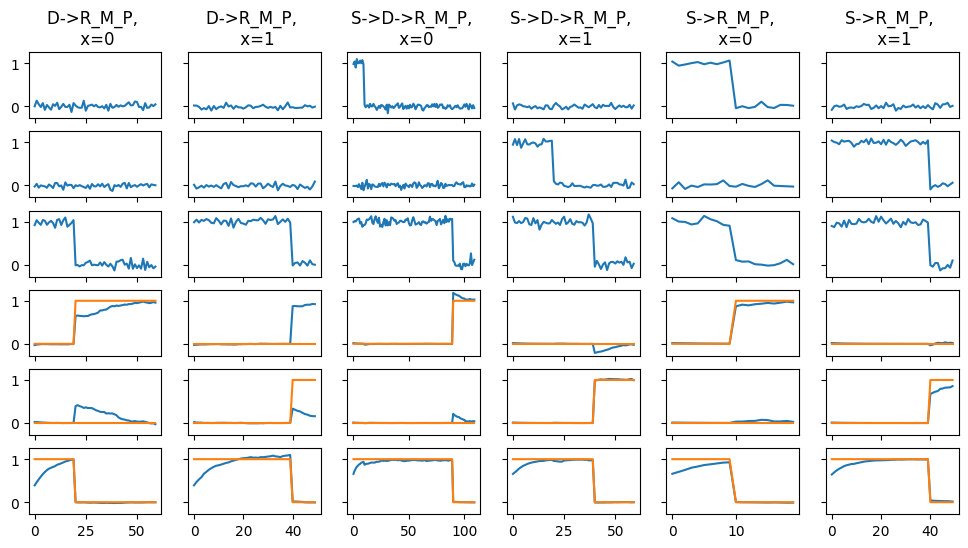

In [8]:
i_ckpt = -1
ckpt = ckpt_list[i_ckpt]
model.load_state_dict(ckpt)

sig_y = 0
sig_s = config['sig_s']
p_stay = config['p_stay']
min_Te = config['min_Te']

epoch_str_list = ['D->R_M_P', 'S->D->R_M_P', 'S->R_M_P']
# epoch_str_list = ['F/D->R_P', 'S->F/D->R_P', 'S->R_P']
# epoch_str_list = ['F/D->R_A', 'S->F/D->R_A', 'S->R_A']
# epoch_str_list = ['F/D->R_M_P', 'S->F/D->R_M_P', 'S->R_M_P']
# epoch_str_list = ['F/D->R_M_P', 'F/D->R_M_A']
# epoch_str_list = ['S->F/D->R_M_P', 'S->F/D->R_M_A']
x_set = np.arange(config['nx'])
fig, axes = plt.subplots(6, len(epoch_str_list) * len(x_set), 
                         figsize=(2 * len(epoch_str_list) * len(x_set), 6), 
                         sharey=True, sharex='col')

for itask, epoch_str in enumerate(epoch_str_list):
    for ix, x in enumerate(x_set):
        sy, boundaries = compose_trial(epoch_str, {'theta_task': x}, sig_s, sig_y, p_stay, min_Te, d_stim=d_stim)
        all_Te = np.diff([0] + list(boundaries))
        z = [[config['z_list'].index(cur)] * Te for cur, Te in zip(epoch_str.split('->'), all_Te)]
        z = np.array([j for i in z for j in i])[:, None]
        if config.get('fixation_type', 1) == 2:
            sy['s'][:, -1] = 1 - sy['s'][:, -1]
            sy['y'][:, -1] = 1 - sy['y'][:, -1]
        syz = np.concatenate([sy['s'], sy['y'], z], axis=-1)
        syz = torch.tensor(syz[:, None, :], dtype=torch.float32)
        syz = syz.to(next(model.parameters()).device)
        s, y, z = syz[..., :3], syz[..., 3:6], syz[..., -1]
        z = F.one_hot(z.to(torch.int64), num_classes=dim_z).float()
        with torch.no_grad():
            out = model(s, z)
        ########### plot #########
        icol = len(x_set) * itask + ix
        axes[0, icol].set_title(f'{epoch_str}, \n x={x}')
        for iax in range(3):
            axes[iax, icol].plot(s[:, :, iax].cpu().numpy())
        for iax in range(3):
            axes[iax + 3, icol].plot(out[:, :, iax].cpu().numpy())
            axes[iax + 3, icol].plot(y[:, :, iax].cpu().numpy())